# 1. Importing Packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


# 2. Loading Data

In [2]:
project_data = pd.read_csv('D:\\train_data.csv',nrows = 50000)
resource_data = pd.read_csv('D:\\resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('='*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in resources data", resource_data.shape)
print(resource_data.columns.values)

Number of data points in resources data (1541272, 4)
['id' 'description' 'quantity' 'price']


In [5]:
resource_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [6]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

In [7]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [8]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [9]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [10]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.NaN,'Mrs.')

# 3. Text Preprocessing

# 3.1. Concatenating all essay text

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

# 3.2. Preprocessing Essay text

In [12]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[49999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent = decontracted(project_data['essay'].values[16499])
print(sent)
print("="*50) 

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [15]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

I teach an amazing energetic engaged and kind group of 5th grade students in an inner city high poverty public school in Indianapolis Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children My students work hard in class giving 110 with everything that they do They persevere through difficult topics enjoy being engaged in their hands on activities and they love to laugh while learning I set high expectation for my students They understand that true authentic learning takes hard work dedication and requires them to take ownership over their education My goal for my students is to leave my class as life long learners The students work hard to overcome all obstacles in their path to meet and grow past my expectations My students love being active while they are learning and wiggling while they are working I am lucky enough to have one Hokki stools in my classroom Sadly one is not enough to reach all my students My student

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [18]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = sent.lower()
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:44<00:00, 1117.11it/s]


In [19]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [20]:
project_data['preprocessed_essays'] = preprocessed_essays 
project_data.drop(['essay'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  
0        23  students english learners working english seco...  
1         1  students arrive school eager learn polite gene...

# 3.3. Preprocessing Title text

In [21]:
# printing some random titles.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[49999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Young Authors Through Reading


In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
title = decontracted(project_data['project_title'].values[20000])
print(title)
print("="*50)

We Need To Move It While We Input It!


In [24]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
title = title.replace('\\r', ' ')
title = title.replace('\\"', ' ')
title = title.replace('\\n', ' ')
print(title)

We Need To Move It While We Input It!


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
title = re.sub('[^A-Za-z0-9]+', ' ', title)
print(title)

We Need To Move It While We Input It 


In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [27]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for t in tqdm(project_data['project_title'].values):
    title = decontracted(t)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = title.lower()
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.strip())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 24404.17it/s]


In [28]:
# after preprocesing
preprocessed_titles[20000]

'need move input'

In [29]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles  
0  educational support english learners home  
1           wanted projector hungry learners

In [30]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles  
0  educational support english learners home  
1           wanted projector hungry learners

# 3.4. Preprocessing project_grade_category

In [31]:
project_grade_clean_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-", "_")
    project_grade_clean_category.append(a)

In [32]:
project_grade_clean_category[0:5]

['Grades_PreK_2', 'Grades_6_8', 'Grades_6_8', 'Grades_PreK_2', 'Grades_PreK_2']

In [33]:
project_data['project_grade_clean_category'] = project_grade_clean_category 
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime         project_subject_categories  \
0           IN        2016-12-05 13:43:57                Literacy & Language   
1           FL        2016-10-25 09:22:10  History & Civics, Health & Sports   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  
0  educational support english learners home                Grades_PreK_2  
1           wanted projector hungry learners                   Grades_6_8

# 3.5. Preprocessing project_subject_categories

In [34]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [35]:
cat_list[0:5]

['Literacy_Language',
 'History_Civics Health_Sports',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Math_Science']

In [36]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime     project_subject_subcategories  \
0           IN        2016-12-05 13:43:57                     ESL, Literacy   
1           FL        2016-10-25 09:22:10  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

# 3.5. Preprocessing project_subject_subcategories

In [37]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [38]:
sub_cat_list[0:5]

['ESL Literacy',
 'Civics_Government TeamSports',
 'Health_Wellness TeamSports',
 'Literacy Mathematics',
 'Mathematics']

In [39]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

# 4. Splitting data into Train and cross validation(or test): Stratified Sampling

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 5. Dropping Target values from Train, Test and CV set

In [41]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

In [42]:
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(22445, 19)
(16500, 19)
(11055, 19)


In [43]:
X_train.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
28410      125185  p064937  fc645aa5ab5d027240470d73990fd342            Ms.   
47890      137201  p174257  e8de8eeacaf1917f459e3fdde2280195            Ms.   
23626      177892  p013052  202339c54a2f63bbb1f039a0576a4c43           Mrs.   
28728      107880  p024674  b4ab661c368aec8b51068192dfca072a            Ms.   
47884       72338  p245028  0d8202ddd7cf14d6eb0985a8af05b594            Mr.   

      school_state project_submitted_datetime  \
28410           NY        2016-12-12 18:51:20   
47890           NY        2017-02-26 11:28:17   
23626           HI        2017-03-02 15:24:16   
28728           TX        2016-08-31 16:01:50   
47884           MI        2017-01-04 21:25:31   

                                         project_essay_1  \
28410  Our school is the hub of our urban community i...   
47890  My students are kindergarteners who are learni...   
23626  We attend a small K-6 school in Hawaii.Our thi...   
28728  My students are as diverse as you can get. I h...   
47884  Have you ever interacted with a group of kids ...   

                                         project_essay_2 project_essay_3  \
28410  Digital projection cameras will bring learning...             NaN   
47890  My students love to learn and they love to rea...             NaN   
23626  Reading gives students an opportunity to go on...             NaN   
28728  Our students live and work in the age of techn...             NaN   
47884  I am requesting stage lighting equipment to he...             NaN   

      project_essay_4                           project_resource_summary  \
28410             NaN  My students need digital projection cameras to...   
47890             NaN  My students need sets of guided reading and bi...   
23626             NaN  My students need a class set of Calving Coconu...   
28728             NaN  My students need Kindle Fires to use for indep...   
47884             NaN  My students need stage lighting equipment to a...   

       teacher_number_of_previously_posted_projects   price  quantity  \
28410                                             2   85.21         3   
47890                                             0  217.90        11   
23626                                            12  159.43        67   
28728                                             0   99.99         3   
47884                                             6  426.37        10   

                                     preprocessed_essays  \
28410  school hub urban community bronx ny staff welc...   
47890  students kindergarteners learning spanish dual...   
23626  attend small k 6 school hawaii third grade cla...   
28728  students diverse get students reading kinderga...   
47884  ever interacted group kids realized not know p...   

                                     preprocessed_titles  \
28410  click bringing learning life digital projectio...   
47890                                   big little books   
23626                          books open door adventure   
28728                                      fired reading   
47884                                      turned lights   

      project_grade_clean_category                clean_categories  \
28410                Grades_PreK_2  Literacy_Language Math_Science   
47890                Grades_PreK_2               Literacy_Language   
23626                   Grades_3_5               Literacy_Language   
28728                   Grades_3_5  Literacy_Language SpecialNeeds   
47884                   Grades_6_8                      Music_Arts   

                  clean_subcategories  
28410  Literature_Writing Mathematics  
47890       ForeignLanguages Literacy  
23626                        Literacy  
28728           Literacy SpecialNeeds  
47884       PerformingArts VisualArts

In [44]:
y_train.head()

28410    1
47890    1
23626    1
28728    1
47884    1
Name: project_is_approved, dtype: int64

# 6. Encoding Categorical Data

# 6.1. One Hot Encoding of clean_categories

In [45]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['clean_categories'].values:
#     my_counter.update(word.split())

# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# cat_dict = dict(my_counter)
# sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [46]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(lowercase=False, binary=True)
vectorizer1.fit(X_train['clean_categories'].values)
print(vectorizer1.get_feature_names())


categories_one_hot_Xtrain = vectorizer1.transform(X_train['clean_categories'].values)
categories_one_hot_Xtest = vectorizer1.transform(X_test['clean_categories'].values)
categories_one_hot_Xcv = vectorizer1.transform(X_cv['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xtest.shape)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xcv.shape)

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of matrix after one hot encodig  (22445, 9)
Shape of matrix after one hot encodig  (16500, 9)
Shape of matrix after one hot encodig  (11055, 9)


# 6.2. One Hot Encoding of clean_subcategories

In [47]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['clean_subcategories'].values:
#     my_counter.update(word.split())

# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# sub_cat_dict = dict(my_counter)
# sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [48]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer2 = CountVectorizer(lowercase=False, binary=True)
vectorizer2.fit(project_data['clean_subcategories'].values)
print(vectorizer2.get_feature_names())


sub_categories_one_hot_Xtrain = vectorizer2.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_Xtest = vectorizer2.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_Xcv = vectorizer2.transform(X_cv['clean_subcategories'].values)

print("Shape of matrix after one hot encoding ",sub_categories_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_Xtest.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_Xcv.shape)

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of matrix after one hot encoding  (22445, 30)
Shape of matrix after one hot encodig  (16500, 30)
Shape of matrix after one hot encodig  (11055, 30)


# 6.3. One Hot Encoding of school_state

In [49]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['school_state'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# school_state_dict = dict(my_counter)
# sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

In [50]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer3 = CountVectorizer(lowercase=False, binary=True)
vectorizer3.fit(project_data['school_state'].values)
print(vectorizer3.get_feature_names())


school_state_one_hot_Xtrain = vectorizer3.transform(X_train['school_state'].values)
school_state_one_hot_Xtest = vectorizer3.transform(X_test['school_state'].values)
school_state_one_hot_Xcv = vectorizer3.transform(X_cv['school_state'].values)

print("Shape of matrix after one hot encoding ",school_state_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",school_state_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",school_state_one_hot_Xcv.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encoding  (22445, 51)
Shape of matrix after one hot encoding  (16500, 51)
Shape of matrix after one hot encoding  (11055, 51)


# 6.4. One Hot Encoding of teacher_prefix

In [51]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['teacher_prefix'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# teacher_prefix_dict = dict(my_counter)
# sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

In [52]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer4 = CountVectorizer(lowercase=False, binary=True)
vectorizer4.fit(project_data['teacher_prefix'].values)
print(vectorizer4.get_feature_names())


teacher_prefix_one_hot_Xtrain = vectorizer4.transform(X_train['teacher_prefix'].values)
teacher_prefix_one_hot_Xtest = vectorizer4.transform(X_test['teacher_prefix'].values)
teacher_prefix_one_hot_Xcv = vectorizer4.transform(X_cv['teacher_prefix'].values)

print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xcv.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encoding  (22445, 5)
Shape of matrix after one hot encoding  (16500, 5)
Shape of matrix after one hot encoding  (11055, 5)


# 6.5. One Hot Encoding of project_grade_clean_category

In [53]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['project_grade_clean_category'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# grade_dict = dict(my_counter)
# sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))

In [54]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer5 = CountVectorizer(lowercase=False, binary=True)
vectorizer5.fit(project_data['project_grade_clean_category'].values)
print(vectorizer5.get_feature_names())


grade_one_hot_Xtrain = vectorizer5.transform(X_train['project_grade_clean_category'].values)
grade_one_hot_Xtest = vectorizer5.transform(X_test['project_grade_clean_category'].values)
grade_one_hot_Xcv = vectorizer5.transform(X_cv['project_grade_clean_category'].values)

print("Shape of matrix after one hot encoding ",grade_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_Xcv.shape)

['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
Shape of matrix after one hot encoding  (22445, 4)
Shape of matrix after one hot encoding  (16500, 4)
Shape of matrix after one hot encoding  (11055, 4)


# 7. Encoding of Text Data

# 7.1.  BOW encoding of preprocessed_essays

In [55]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer6 = CountVectorizer(min_df=5)
text_bow_Xtrain = vectorizer6.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtrain.shape)
text_bow_Xtest = vectorizer6.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtest.shape)
text_bow_Xcv = vectorizer6.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 11969)
Shape of matrix after one hot encodig  (16500, 11969)
Shape of matrix after one hot encodig  (11055, 11969)


# 7.2. BOW encoding of preprocessed_titles

In [56]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer7 = CountVectorizer(min_df=5)
title_bow_Xtrain = vectorizer7.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtrain.shape)
title_bow_Xtest = vectorizer7.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtest.shape)
title_bow_Xcv = vectorizer7.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 2032)
Shape of matrix after one hot encodig  (16500, 2032)
Shape of matrix after one hot encodig  (11055, 2032)


# 7.3. TFIDF encoding of preprocessed_essays

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer8 = TfidfVectorizer(min_df=5)
text_tfidf_Xtrain = vectorizer8.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtrain.shape)
text_tfidf_Xtest = vectorizer8.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtest.shape)
text_tfidf_Xcv = vectorizer8.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 11969)
Shape of matrix after one hot encodig  (16500, 11969)
Shape of matrix after one hot encodig  (11055, 11969)


# 7.4. TFIDF encoding of preprocessed_titles

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer9 = TfidfVectorizer(min_df=5)
title_tfidf_Xtrain = vectorizer9.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtrain.shape)
title_tfidf_Xtest = vectorizer9.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtest.shape)
title_tfidf_Xcv = vectorizer9.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 2032)
Shape of matrix after one hot encodig  (16500, 2032)
Shape of matrix after one hot encodig  (11055, 2032)


# 7.5. Average Word2Vec encoding of preprocessed_essays on Train Data

In [59]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('D:\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [60]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtrain.append(vector)

print(len(avg_w2v_vectors_essays_Xtrain))
print(len(avg_w2v_vectors_essays_Xtrain[2]))

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:11<00:00, 1920.87it/s]


22445
300


In [61]:
average_w2v_on_essay_Xtrain = np.vstack(avg_w2v_vectors_essays_Xtrain)
print(average_w2v_on_essay_Xtrain.shape)

(22445, 300)


# 7.6. Average Word2Vec encoding of preprocessed_essays on Test Data

In [62]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtest.append(vector)

print(len(avg_w2v_vectors_essays_Xtest))
print(len(avg_w2v_vectors_essays_Xtest[2]))

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:08<00:00, 2011.42it/s]


16500
300


In [63]:
average_w2v_on_essay_Xtest = np.vstack(avg_w2v_vectors_essays_Xtest)
print(average_w2v_on_essay_Xtest.shape)

(16500, 300)


# 7.7. Average Word2Vec encoding of preprocessed_essays on CV Data

In [64]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xcv.append(vector)

print(len(avg_w2v_vectors_essays_Xcv))
print(len(avg_w2v_vectors_essays_Xcv[2]))

100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:05<00:00, 2028.02it/s]


11055
300


In [65]:
average_w2v_on_essay_Xcv = np.vstack(avg_w2v_vectors_essays_Xcv)
print(average_w2v_on_essay_Xcv.shape)

(11055, 300)


# 7.8. Average Word2Vec encoding of preprocessed_titles on Train Data

In [66]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtrain.append(vector)

print(len(avg_w2v_vectors_titles_Xtrain))
print(len(avg_w2v_vectors_titles_Xtrain[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:00<00:00, 36576.35it/s]


22445
300


In [67]:
average_w2v_on_titles_Xtrain = np.vstack(avg_w2v_vectors_titles_Xtrain)
print(average_w2v_on_titles_Xtrain.shape)

(22445, 300)


# 7.9. Average Word2Vec encoding of preprocessed_titles on Test Data

In [68]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtest.append(vector)

print(len(avg_w2v_vectors_titles_Xtest))
print(len(avg_w2v_vectors_titles_Xtest[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 36125.61it/s]


16500
300


In [69]:
average_w2v_on_titles_Xtest = np.vstack(avg_w2v_vectors_titles_Xtest)
print(average_w2v_on_titles_Xtest.shape)

(16500, 300)


# 7.10. Average Word2Vec encoding of preprocessed_titles on CV Data

In [70]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xcv.append(vector)

print(len(avg_w2v_vectors_titles_Xcv))
print(len(avg_w2v_vectors_titles_Xcv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 38274.73it/s]


11055
300


In [71]:
average_w2v_on_titles_Xcv = np.vstack(avg_w2v_vectors_titles_Xcv)
print(average_w2v_on_titles_Xcv.shape)

(11055, 300)


# 7.11. TFIDF weighted Word2Vec encoding of preprocessed_essays on Train Data

In [72]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [73]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain[0]))

100%|███████████████████████████████████████████████████████████████████████████| 22445/22445 [01:11<00:00, 312.84it/s]


22445
300


In [74]:
tfidf_weighted_w2v_on_essay_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtrain)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)

(22445, 300)


# 7.12. TFIDF weighted Word2Vec encoding of preprocessed_essays on Test Data

In [75]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [76]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtest))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtest[0]))

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [00:49<00:00, 333.10it/s]


16500
300


In [77]:
tfidf_weighted_w2v_on_essay_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtest)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)

(16500, 300)


# 7.13. TFIDF weighted Word2Vec encoding of preprocessed_essays on CV Data

In [78]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [79]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xcv))
print(len(tfidf_weighted_w2v_vectors_eassays_Xcv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 11055/11055 [00:36<00:00, 303.72it/s]


11055
300


In [80]:
tfidf_weighted_w2v_on_essay_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xcv)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)

(11055, 300)


# 7.14. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Train Data

In [81]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [82]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtrain))
print(len(tfidf_weighted_w2v_vectors_title_Xtrain[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:01<00:00, 19972.05it/s]


22445
300


In [83]:
tfidf_weighted_w2v_on_title_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_title_Xtrain)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)

(22445, 300)


# 7.15. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Test Data

In [84]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [85]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtest))
print(len(tfidf_weighted_w2v_vectors_title_Xtest[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:01<00:00, 16407.45it/s]


16500
300


In [86]:
tfidf_weighted_w2v_on_title_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_title_Xtest)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)

(16500, 300)


# 7.16. TFIDF Weighted Word2Vec encoding of preprocessed_titles on CV Data

In [87]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [88]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xcv))
print(len(tfidf_weighted_w2v_vectors_title_Xcv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 15712.21it/s]


11055
300


In [89]:
tfidf_weighted_w2v_on_title_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_title_Xcv)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)

(11055, 300)


# 8. Encoding of Numerical Data

# 8.1. Encoding of price on Train,Test and CV data

In [90]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler


scalar = MinMaxScaler()
 
price_standardized_Xtrain = scalar.fit_transform(X_train['price'].values.reshape(-1, 1))
price_standardized_Xtest = scalar.transform(X_test['price'].values.reshape(-1,1))
price_standardized_Xcv = scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [91]:
price_standardized_Xtrain

array([[0.0084564 ],
       [0.02172761],
       [0.01587964],
       ...,
       [0.02642939],
       [0.00493382],
       [0.03008499]])

In [92]:
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)

(22445, 1)
(16500, 1)
(11055, 1)


# 8.4. Encoding of quantity on Train,Test and CV data

In [93]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

quantity_standardized_Xtrain = scalar.fit_transform(X_train['quantity'].values.reshape(-1, 1))
quantity_standardized_Xtest = scalar.transform(X_test['quantity'].values.reshape(-1, 1))
quantity_standardized_Xcv = scalar.transform(X_cv['quantity'].values.reshape(-1, 1))

In [94]:
quantity_standardized_Xtrain

array([[0.00222469],
       [0.01112347],
       [0.07341491],
       ...,
       [0.00889878],
       [0.00222469],
       [0.02558398]])

In [95]:
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)

(22445, 1)
(16500, 1)
(11055, 1)


# 8.7. Encoding of teacher_number_of_previously_posted_projects on Train,Test and CV data

In [96]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

# Now standardize the data with above maen and variance.
teacher_number_of_previously_posted_projects_standardized_Xtrain = scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_number_of_previously_posted_projects_standardized_Xtest = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 
teacher_number_of_previously_posted_projects_standardized_Xcv = scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 

In [97]:
teacher_number_of_previously_posted_projects_standardized_Xtrain

array([[0.00487805],
       [0.        ],
       [0.02926829],
       ...,
       [0.00243902],
       [0.00487805],
       [0.00243902]])

In [98]:
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv.shape)

(22445, 1)
(16500, 1)
(11055, 1)


# 9. Printing Dimensions of all Preprocessed Data

In [99]:
print(categories_one_hot_Xtrain.shape)
print(categories_one_hot_Xtest.shape)
print(categories_one_hot_Xcv.shape)
print(sub_categories_one_hot_Xtrain.shape)
print(sub_categories_one_hot_Xtest.shape)
print(sub_categories_one_hot_Xcv.shape)
print(school_state_one_hot_Xtrain.shape)
print(school_state_one_hot_Xtest.shape)
print(school_state_one_hot_Xcv.shape)
print(teacher_prefix_one_hot_Xtrain.shape)
print(teacher_prefix_one_hot_Xtest.shape)
print(teacher_prefix_one_hot_Xcv.shape)
print(grade_one_hot_Xtrain.shape)
print(grade_one_hot_Xtest.shape)
print(grade_one_hot_Xcv.shape)
print(text_bow_Xtrain.shape)
print(text_bow_Xtest.shape)
print(text_bow_Xcv.shape)
print(title_bow_Xtrain.shape)
print(title_bow_Xtest.shape)
print(title_bow_Xcv.shape)
print(text_tfidf_Xtrain.shape)
print(text_tfidf_Xtest.shape)
print(text_tfidf_Xcv.shape)
print(title_tfidf_Xtrain.shape)
print(title_tfidf_Xtest.shape)
print(title_tfidf_Xcv.shape)
print(average_w2v_on_essay_Xtrain.shape)
print(average_w2v_on_essay_Xtest.shape)
print(average_w2v_on_essay_Xcv.shape)
print(average_w2v_on_titles_Xtrain.shape)
print(average_w2v_on_titles_Xtest.shape)
print(average_w2v_on_titles_Xcv.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv .shape)

(22445, 9)
(16500, 9)
(11055, 9)
(22445, 30)
(16500, 30)
(11055, 30)
(22445, 51)
(16500, 51)
(11055, 51)
(22445, 5)
(16500, 5)
(11055, 5)
(22445, 4)
(16500, 4)
(11055, 4)
(22445, 11969)
(16500, 11969)
(11055, 11969)
(22445, 2032)
(16500, 2032)
(11055, 2032)
(22445, 11969)
(16500, 11969)
(11055, 11969)
(22445, 2032)
(16500, 2032)
(11055, 2032)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 1)
(16500, 1)
(11055, 1)
(22445, 1)
(16500, 1)
(11055, 1)
(22445, 1)
(16500, 1)
(11055, 1)


# 10. Creating Different Sets of Data for Training Model

# Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)

In [100]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain1 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_bow_Xtrain,title_bow_Xtrain)).tocsr()
Xtest1 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_bow_Xtest,title_bow_Xtest)).tocsr()
Xcv1 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_bow_Xcv,title_bow_Xcv)).tocsr()

print(Xtrain1.shape,y_train.shape)
print(Xtest1.shape,y_test.shape)
print(Xcv1.shape,y_cv.shape)

(22445, 14103) (22445,)
(16500, 14103) (16500,)
(11055, 14103) (11055,)


# Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

In [101]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain2 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_tfidf_Xtrain,title_tfidf_Xtrain)).tocsr()
Xtest2 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_tfidf_Xtest,title_tfidf_Xtest)).tocsr()
Xcv2 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_tfidf_Xcv,title_tfidf_Xcv)).tocsr()

print(Xtrain2.shape,y_train.shape)
print(Xtest2.shape,y_test.shape)
print(Xcv2.shape,y_cv.shape)

(22445, 14103) (22445,)
(16500, 14103) (16500,)
(11055, 14103) (11055,)


# Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

In [102]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain3 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,average_w2v_on_essay_Xtrain,average_w2v_on_titles_Xtrain)).tocsr()
Xtest3 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,average_w2v_on_essay_Xtest,average_w2v_on_titles_Xtest)).tocsr()
Xcv3 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,average_w2v_on_essay_Xcv,average_w2v_on_titles_Xcv)).tocsr()

print(Xtrain3.shape,y_train.shape)
print(Xtest3.shape,y_test.shape)
print(Xcv3.shape,y_cv.shape)

(22445, 702) (22445,)
(16500, 702) (16500,)
(11055, 702) (11055,)


# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

In [103]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain4 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,tfidf_weighted_w2v_on_essay_matrix_Xtrain,tfidf_weighted_w2v_on_title_matrix_Xtrain)).tocsr()
Xtest4 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,tfidf_weighted_w2v_on_essay_matrix_Xtest,tfidf_weighted_w2v_on_title_matrix_Xtest)).tocsr()
Xcv4 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,tfidf_weighted_w2v_on_essay_matrix_Xcv,tfidf_weighted_w2v_on_title_matrix_Xcv)).tocsr()

print(Xtrain4.shape,y_train.shape)
print(Xtest4.shape,y_test.shape)
print(Xcv4.shape,y_cv.shape)

(22445, 702) (22445,)
(16500, 702) (16500,)
(11055, 702) (11055,)


# 11. Appling Decision Tree on different kind of featurization

# 11.1. Applying Decision Trees on BOW, SET 1

# Function for predicting Target values Batchwise

In [107]:
# def batch_predict(clf, data):
#     # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
#     # not the predicted outputs

#     y_data_pred = []
#     tr_loop = data.shape[0] - data.shape[0]%1000
#     # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
#     # in this for loop we will iterate unti the last 1000 multiplier
#     for i in range(0, tr_loop, 1000):
#         y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
#     # we will be predicting for the last data points
#     if data.shape[0]%1000 !=0:
#         y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
#     return y_data_pred

# 11.1.1. Finding The Best Hyperparameter "max_depth" and "min_samples_split"

In [170]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb


DT = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth':(1,5,10,50,100,500) , 'min_samples_split':(5,10,100,500)}
DTREE = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
DTREE.fit(Xtrain1, y_train)
print(DTREE.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


# 11.1.2. Creating Data For Heatmap 

In [171]:
DTREE = pd.DataFrame.from_dict(DTREE.cv_results_)

In [172]:
# DTREE = pd.DataFrame(DTREE.cv_results_)

In [173]:
DTREE.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.191485      0.049815         0.015628    5.234360e-06   
1       0.162516      0.007784         0.011922    3.071434e-03   
2       0.156255      0.000011         0.015601    9.989584e-07   
3       0.156248      0.000009         0.015632    5.939766e-06   
4       0.609346      0.012748         0.015631    6.899965e-06   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.570889   
1   {'max_depth': 1, 'min_samples_split': 10}           0.570889   
2  {'max_depth': 1, 'min_samples_split': 100}           0.570889   
3  {'max_depth': 1, 'min_samples_split': 500}           0.570889   
4    {'max_depth': 5, 'min_samples_split': 5}           0.646931   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.575549           0.567741         0.571393        0.003207   
1           0.575549           0.567741         0.571393        0.003207   
2           0.575549           0.567741         0.571393        0.003207   
3           0.575549           0.567741         0.571393        0.003207   
4           0.665551           0.648754         0.653745        0.008381   

   rank_test_score  split0_train_score  split1_train_score  \
0               18            0.580718            0.578385   
1               18            0.580718            0.578385   
2               18            0.580718            0.578385   
3               18            0.580718            0.578385   
4                8            0.697347            0.687338   

   split2_train_score  mean_train_score  std_train_score  
0            0.567801          0.575635         0.005620  
1            0.567801          0.575635         0.005620  
2            0.567801          0.575635         0.005620  
3            0.567801          0.575635         0.005620  
4            0.686951          0.690545         0.004812

In [174]:
max_scores_bow = DTREE.groupby(['param_min_samples_split', 
                                    'param_max_depth']).max()

In [175]:
max_scores_bow.head()

mean_fit_time  std_fit_time  \
param_min_samples_split param_max_depth                                
5                       1                     0.191485      0.049815   
                        5                     0.609346      0.012748   
                        10                    2.171725      0.132587   
                        50                    8.442153      0.194873   
                        100                  11.686723      0.232082   

                                         mean_score_time  std_score_time  \
param_min_samples_split param_max_depth                                    
5                       1                       0.015628    5.234360e-06   
                        5                       0.015631    6.899965e-06   
                        10                      0.015634    8.050722e-06   
                        50                      0.020832    7.363392e-03   
                        100                     0.015625    3.893359e-07   

                                                                             params  \
param_min_samples_split param_max_depth                                               
5                       1                  {'max_depth': 1, 'min_samples_split': 5}   
                        5                  {'max_depth': 5, 'min_samples_split': 5}   
                        10                {'max_depth': 10, 'min_samples_split': 5}   
                        50                {'max_depth': 50, 'min_samples_split': 5}   
                        100              {'max_depth': 100, 'min_samples_split': 5}   

                                         split0_test_score  split1_test_score  \
param_min_samples_split param_max_depth                                         
5                       1                         0.570889           0.575549   
                        5                         0.646931           0.665551   
                        10                        0.648751           0.676900   
                        50                        0.581579           0.593183   
                        100                       0.562316           0.565534   

                                         split2_test_score  mean_test_score  \
param_min_samples_split param_max_depth                                       
5                       1                         0.567741         0.571393   
                        5                         0.648754         0.653745   
                        10                        0.662878         0.662842   
                        50                        0.583680         0.586147   
                        100                       0.567113         0.564988   

                                         std_test_score  rank_test_score  \
param_min_samples_split param_max_depth                                    
5                       1                      0.003207               18   
                        5                      0.008381                8   
                        10                     0.011492                4   
                        50                     0.005049               15   
                        100                    0.001996               23   

                                         split0_train_score  \
param_min_samples_split param_max_depth                       
5                       1                          0.580718   
                        5                          0.697347   
                        10                         0.813617   
                        50                         0.975413   
                        100                        0.993722   

                                         split1_train_score  \
param_min_samples_split param_max_depth                       
5                       1                          0.578385   
                        5                          0.687338   
                        10                  

In [176]:
max_scores_bow = max_scores_bow.unstack()[['mean_test_score', 'mean_train_score']]

In [177]:
max_scores_bow.head()

mean_test_score                                \
param_max_depth                     1         5         10        50    
param_min_samples_split                                                 
5                              0.571393  0.653745  0.662842  0.586147   
10                             0.571393  0.653823  0.663438  0.586661   
100                            0.571393  0.653899  0.664873  0.613356   
500                            0.571393  0.656189  0.675952  0.633867   

                                            mean_train_score            \
param_max_depth               100       500              1         5     
param_min_samples_split                                                  
5                        0.564988  0.562682         0.575635  0.690545   
10                       0.572425  0.570970         0.575635  0.690257   
100                      0.588389  0.578317         0.575635  0.689041   
500                      0.621117  0.613681         0.575635  0.683540   

                                                                 
param_max_depth               10        50        100       500  
param_min_samples_split                                          
5                        0.811215  0.977670  0.994772  0.999907  
10                       0.805745  0.968920  0.990851  0.998263  
100                      0.780447  0.918518  0.956337  0.969146  
500                      0.738674  0.822785  0.834287  0.840569

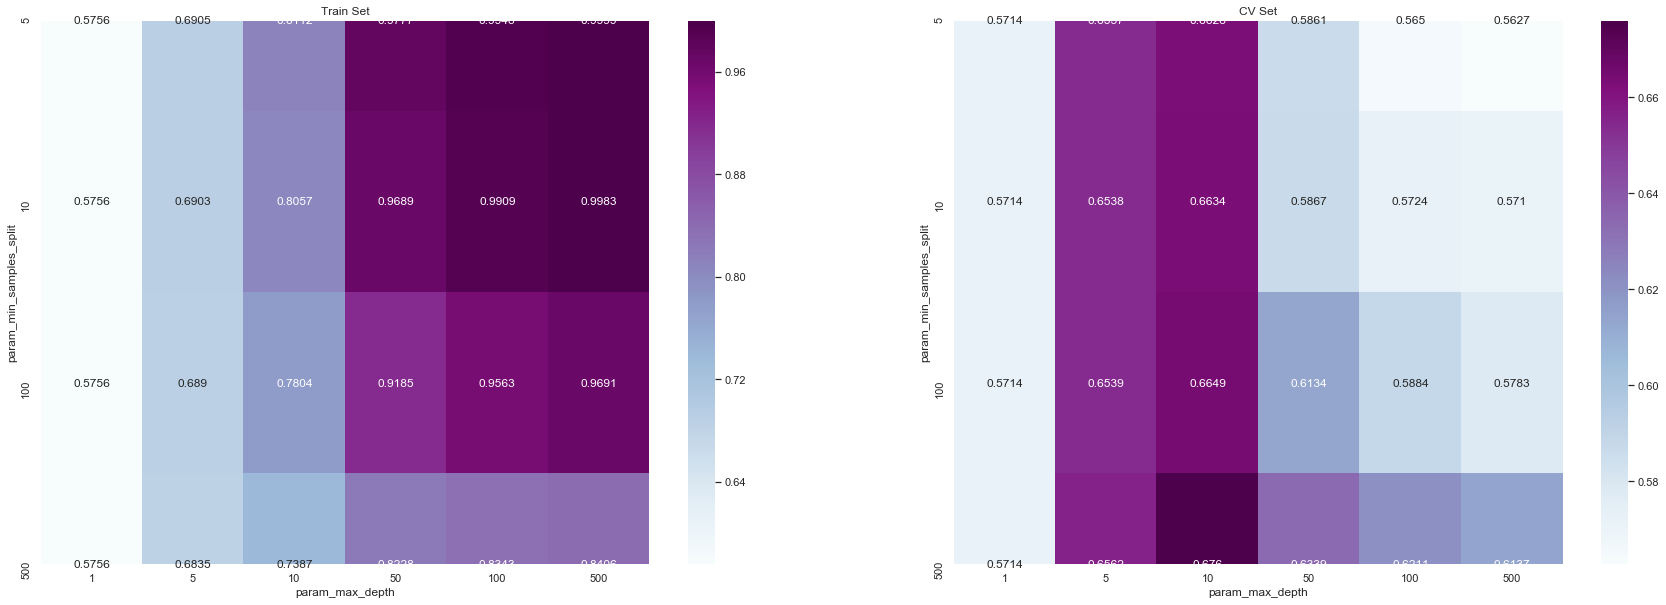

In [178]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_bow.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_bow.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()


# 11.1.3. Testing the performance of the model on test data, plotting ROC Curves

In [179]:
best_parameters_bow = [{'max_depth':[10], 'min_samples_split':[500] } ]

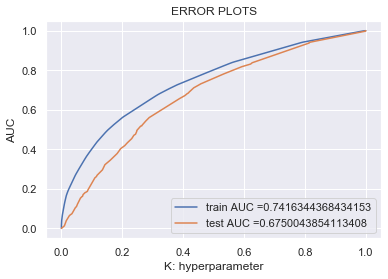

In [180]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


DT1 = DecisionTreeClassifier(class_weight = 'balanced', max_depth=10, min_samples_split=500)
DT1.fit(Xtrain1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = DT1.predict_proba(Xtrain1)[:,1]    
y_test_pred_bow = DT1.predict_proba(Xtest1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.1.4. Building Confusion matrix

In [181]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions_of_y

In [182]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

the maximum value of tpr*(1-fpr) 0.46231550031759505 for threshold 0.495
Train confusion matrix
[[ 2395  1068]
 [ 6293 12689]]
Test confusion matrix
[[1514 1032]
 [4584 9370]]


In [183]:
confusion_matrix_train_bow = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
confusion_matrix_test_bow = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

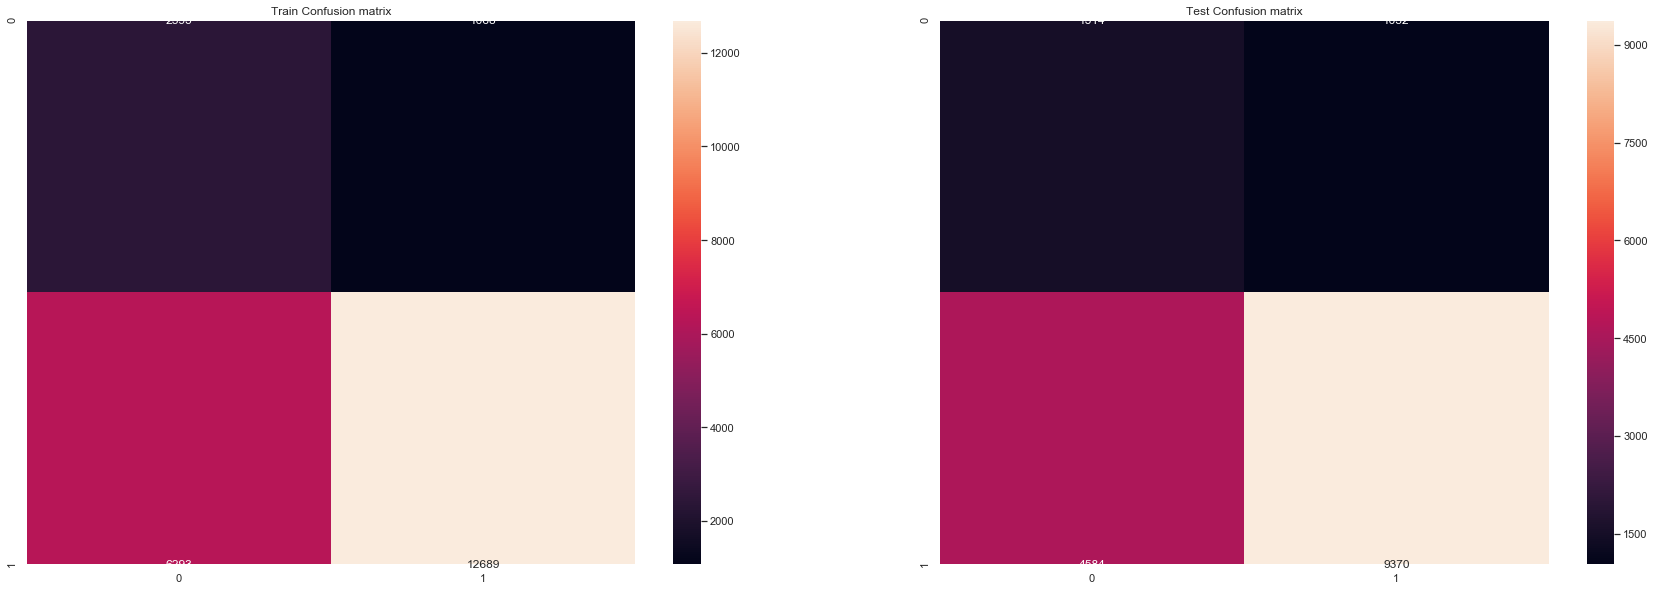

In [184]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_bow,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_bow,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.1.5. Extracting False Positive 

In [185]:
FalsePositive_bow = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions_of_y[i] == 1) :
        FalsePositive_bow.append(i)
fp_essay_bow = []
for i in FalsePositive_bow :
    fp_essay_bow.append(X_test['preprocessed_essays'].values[i])

# 11.1.6. Word Cloud

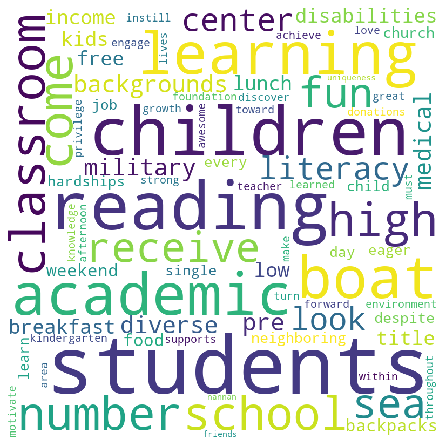

In [186]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay_bow:
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens:
    comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [187]:
cols = X_test.columns

X_test_falsePos_bow = pd.DataFrame(columns=cols)

for i in FalsePositive_bow :   #indexes of false positive points
        X_test_falsePos_bow = X_test_falsePos_bow.append(X_test.filter(items=[i], axis=0))

In [188]:
cols

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'preprocessed_essays', 'preprocessed_titles',
       'project_grade_clean_category', 'clean_categories',
       'clean_subcategories'],
      dtype='object')

In [189]:
X_test_falsePos_bow.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
8       112489  p045029  487448f5226005d08d36bdd75f095b31           Mrs.   
110      48513  p105695  556f373fb3af0e85aa8ea8d19a72dbae            Ms.   
232      88732  p054552  ea528e57aaed6353d1665e7d54a22f7b            Ms.   
323      40195  p068184  22770595aaf1bd535156c9286d612b82            Ms.   
411     158475  p147795  5c57ca197966faa9daf958ce52f138d4           Mrs.   

    school_state project_submitted_datetime  \
8             SC        2016-09-25 17:00:26   
110           LA        2016-07-16 19:49:34   
232           IN        2016-10-19 14:28:50   
323           WI        2017-03-23 16:43:47   
411           OH        2016-05-15 20:00:29   

                                       project_essay_1  \
8    My students are enthusiastic and inquisitive l...   
110  We begin our day hanging our booksacks and tak...   
232  Each day, the students at my school come full ...   
323  My amazing 3, 4 and 5 year-olds are so fun to ...   
411  Every morning we start our \"rug time\" with c...   

                                       project_essay_2  \
8    My second graders need extra activity time dur...   
110  The materials I have requested will allow us m...   
232  Students learn in many different ways. For ins...   
323  Every 4-year-old loves to talk (about everythi...   
411  My students are so excited to learn, but unfor...   

                                       project_essay_3  \
8                                                  NaN   
110                                                NaN   
232                                                NaN   
323                                                NaN   
411  My goal is to help my beginning and at-risk st...   

                                       project_essay_4  \
8                                                  NaN   
110                                                NaN   
232                                                NaN   
323                                                NaN   
411  I expect to see dramatic improvements with mos...   

                              project_resource_summary  \
8    My students need three devices and three manag...   
110  My students need pencils and pencils sharpener...   
232  My students need a new IPad mini and protectiv...   
323  My students need some new seating for reading,...   
411  My students need the Learning Alive software t...   

    teacher_number_of_previously_posted_projects    price quantity  \
8                                             28   241.98        6   
110                                            3   158.35       28   
232                                            0   542.20        3   
323                                            2   222.37        7   
411                                            0  1295.95        1   

                                   preprocessed_essays  \
8    students enthusiastic inquisitive learners k 6...   
110  begin day hanging booksacks taking morning sup...   
232  day students school come full life ready learn...   
323  amazing 3 4 5 year olds fun work focus student...   
411  every morning start rug time calendar weather ...   

           preprocessed_titles project_grade_clean_category  \
8      targeting success class                Grades_PreK_2   
110             super supplies                Grades_PreK_2   
232              ipad learning                   Grades_3_5   
323  education sweet nice seat                Grades_PreK_2   
411  letters numbers come life                Grades_PreK_2   

                      clean_categories             clean_subcategories  
8                        Health_Sports                 Health_Wellness  
110     Literacy_Language Math_Science  Literature_Writing Mathematics  
232     Literacy_Language Math_Science  Literature_Writing Mathematics  
323  AppliedLearning Literacy_Language       EarlyDevelopment Literacy  
411  

In [190]:
print(X_test_falsePos_bow.shape)

(348, 19)


# 11.1.7. Boxplot for 'price' Data

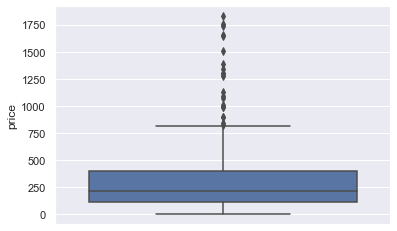

In [191]:
sns.boxplot(y='price', data=X_test_falsePos_bow)

# 11.1.8. PDF and CDF for 'teacher_number_of_previously_posted_projects' data

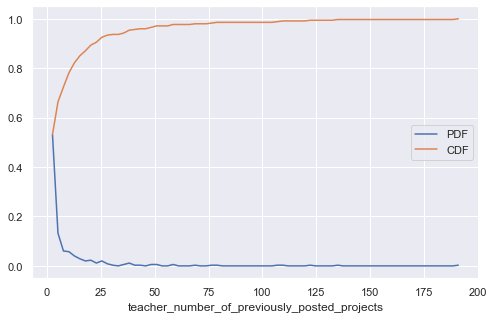

In [192]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos_bow['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

# 11.1.9. Visualizing Decision Tree using Graphviz

In [199]:
#https://stackoverflow.com/questions/32530283/how-to-add-feature-names-to-output-of-decision-tree-in-scikit-learn
#Feature aggregation
f1=vectorizer1.get_feature_names()       #clean_categories
f2=vectorizer2.get_feature_names()       #clean_subcategories
f3=vectorizer3.get_feature_names()       #school_state
f4=vectorizer4.get_feature_names()       #teacher_prefix
f5=vectorizer5.get_feature_names()       #project_grade_clean_category
f6=vectorizer6.get_feature_names()       #preprocessed_esaays with bow
f7=vectorizer7.get_feature_names()       #preprocessed_titles with bow
f8=vectorizer8.get_feature_names()      #preprocessed_esaays with tfidf
f9=vectorizer9.get_feature_names()      #preprocessed_titles with tfidf

feature_agg_bow = f1 + f2 + f3 + f4 + f5 + f6 + f7
feature_agg_tfidf = f1 + f2 + f3 + f4 + f5 + f8 + f9

feature_agg_bow.append('price')
feature_agg_tfidf.append('price')
feature_agg_bow.append('quantity')
feature_agg_tfidf.append('quantity')
feature_agg_bow.append('teacher_number_of_previously_posted_projects')
feature_agg_tfidf.append('teacher_number_of_previously_posted_projects')

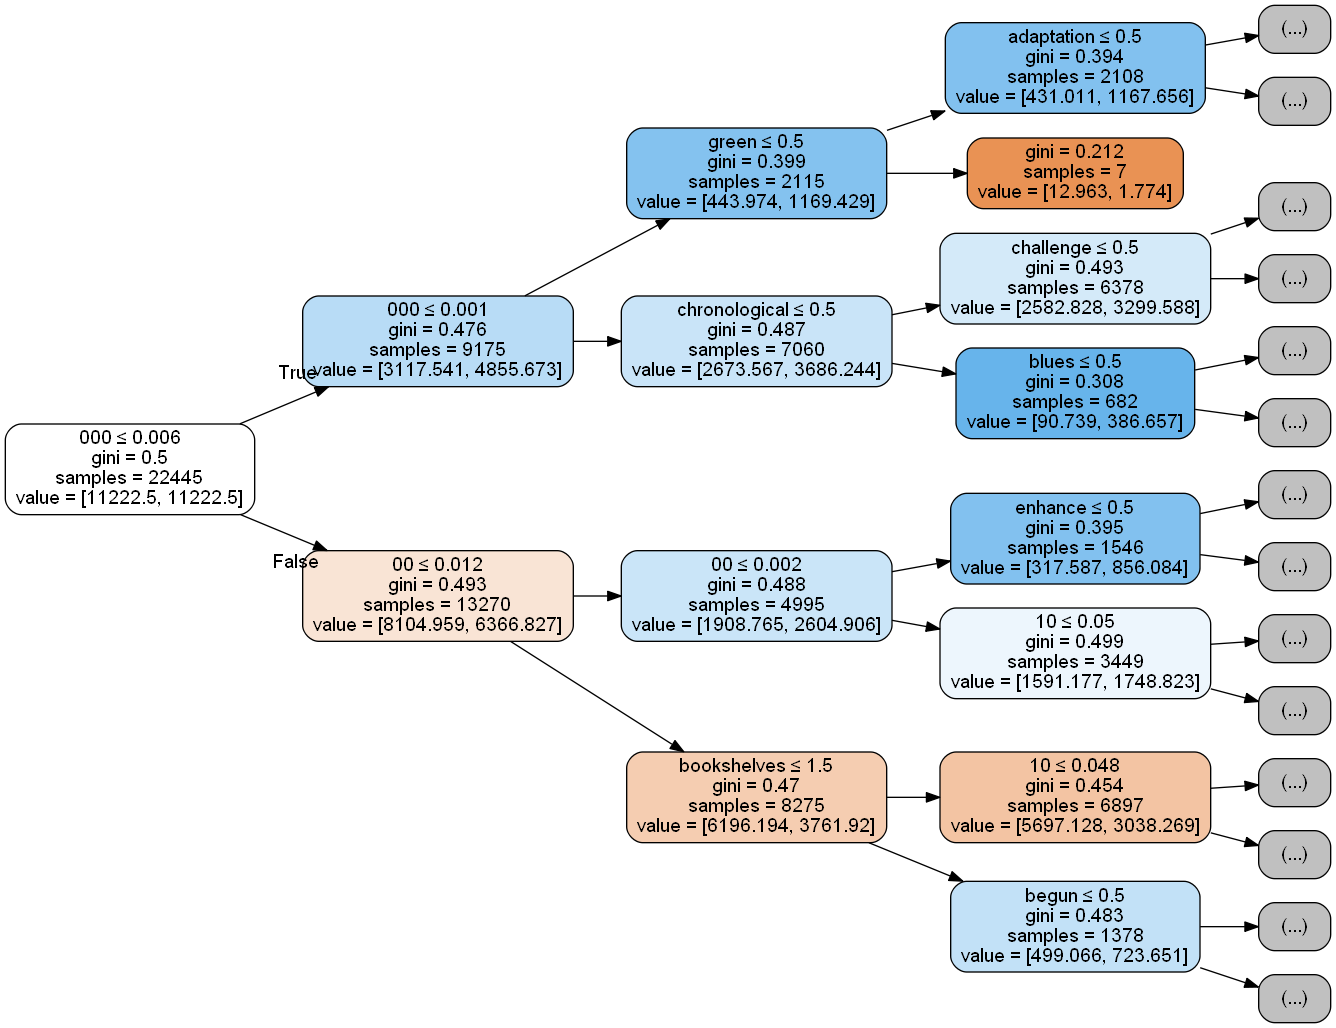

In [200]:
import os 
import graphviz
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from subprocess import call
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
os.environ['PATH'] += os.pathsep+'C:/Program Files (x86)/Graphviz2.38/bin/'
export_graphviz(DT1, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_agg_bow,rotate=True,max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# 11.2. Applying Decision Trees on TFIDF, SET 2

In [104]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb


DT = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth':(1,5,10,50,100,500) , 'min_samples_split':(5,10,100,500)}
DTREE2 = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
DTREE2.fit(Xtrain2, y_train)
print(DTREE2.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


# 11.2.1. Finding The Best Hyperparameter "max_depth" and "min_samples_split"

In [105]:
DTREE2 = pd.DataFrame.from_dict(DTREE2.cv_results_)

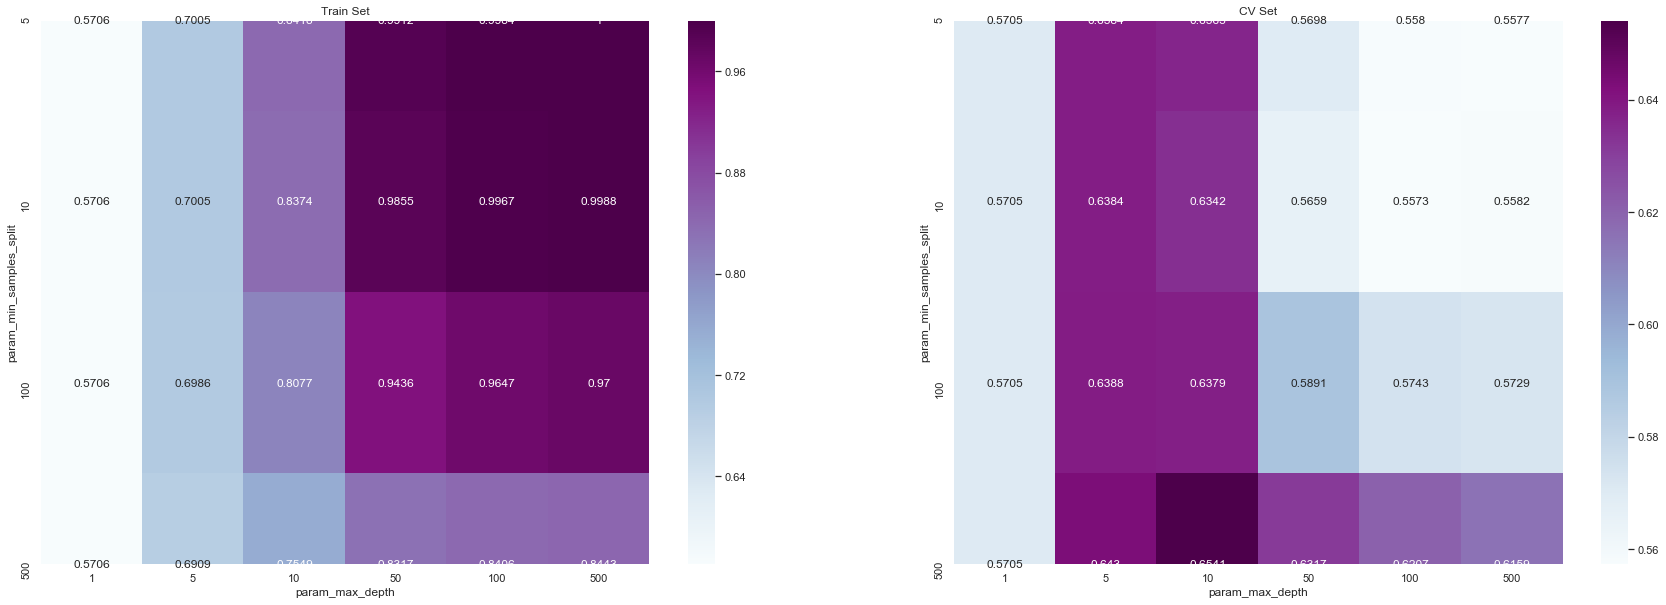

In [106]:
max_scores_tfidf = DTREE2.groupby(['param_min_samples_split', 
                                    'param_max_depth']).max()
max_scores_tfidf = max_scores_tfidf.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_tfidf.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_tfidf.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [107]:
best_parameters_tfidf = [{'max_depth':[10], 'min_samples_split':[500] } ]

# 11.2.2. Testing the performance of the model on test data, plotting ROC Curves

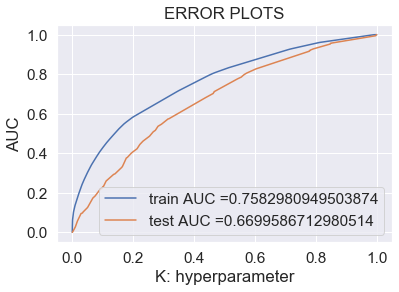

In [205]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


DT2 = DecisionTreeClassifier(class_weight = 'balanced', max_depth= 10 ,min_samples_split =  500)
DT2.fit(Xtrain2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = DT2.predict_proba(Xtrain2)[:,1]    
y_test_pred_tfidf = DT2.predict_proba(Xtest2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.2.3. Visualizing Decision Tree using Graphviz

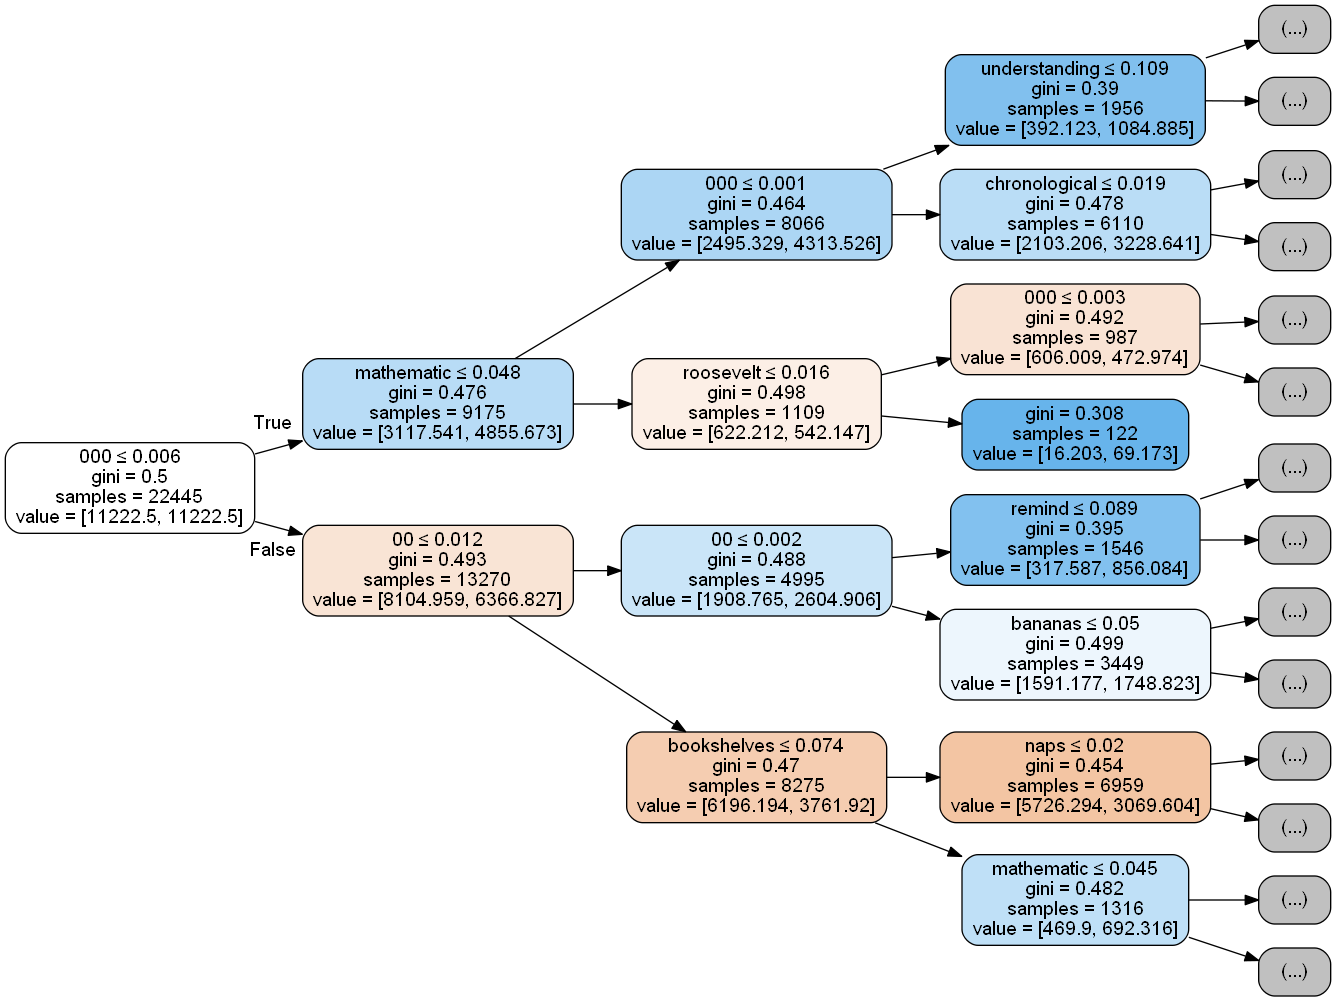

In [206]:
import os 
import graphviz
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from subprocess import call
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
os.environ['PATH'] += os.pathsep+'C:/Program Files (x86)/Graphviz2.38/bin/'
export_graphviz(DT2, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_agg_tfidf,rotate=True,max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# 11.2.4. Buiding Confusion Matrix

In [207]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions_of_y

In [208]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

the maximum value of tpr*(1-fpr) 0.46970747520037603 for threshold 0.47
Train confusion matrix
[[ 2362  1101]
 [ 5910 13072]]
Test confusion matrix
[[1432 1114]
 [4449 9505]]


In [209]:
confusion_matrix_train_tfidf = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
confusion_matrix_test_tfidf = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

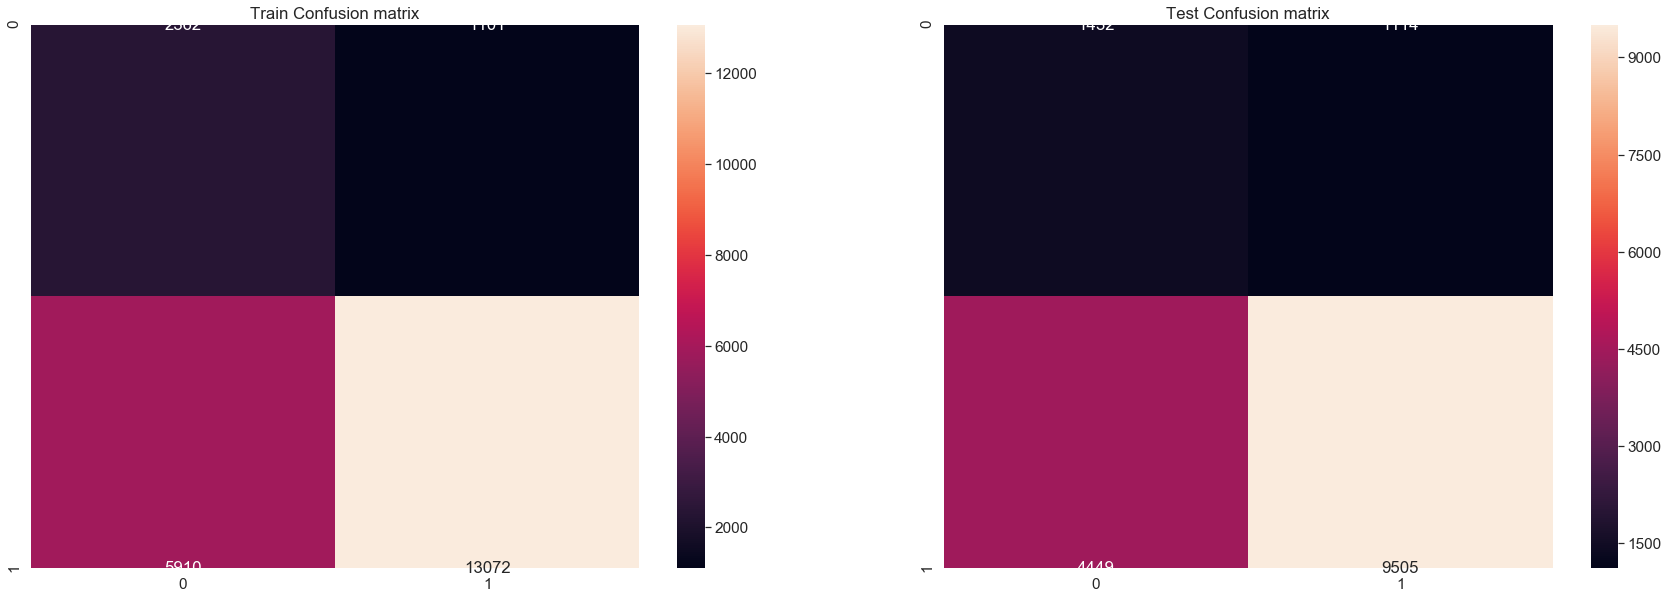

In [210]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.2.5. Extracting False Positives

In [211]:
FalsePositive_tfidf = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions_of_y[i] == 1) :
        FalsePositive_tfidf.append(i)
fp_essay_tfidf = []
for i in FalsePositive_tfidf :
    fp_essay_tfidf.append(X_test['preprocessed_essays'].values[i])

# 11.2.6. Word Cloud

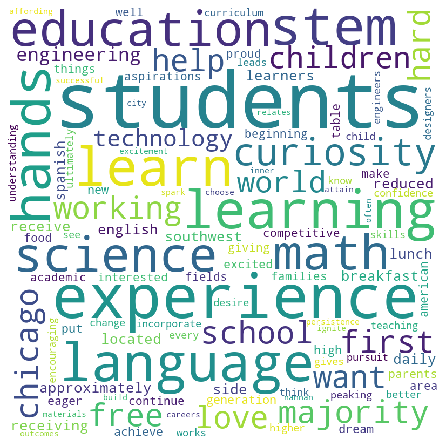

In [212]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay_tfidf :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [213]:
cols = X_test.columns
cols
X_test_falsePos = pd.DataFrame(columns=cols)
# get the data of the false positives
for i in FalsePositive_tfidf : 
        X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i], axis=0))

# 11.2.7 Boxplot for 'price' data

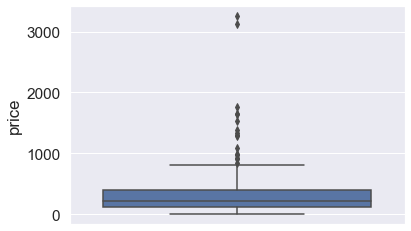

In [214]:
sns.boxplot(y='price', data=X_test_falsePos)

# 11.2.8. PDF and CDF for 'teacher_number_of_previously_posted_projects' data

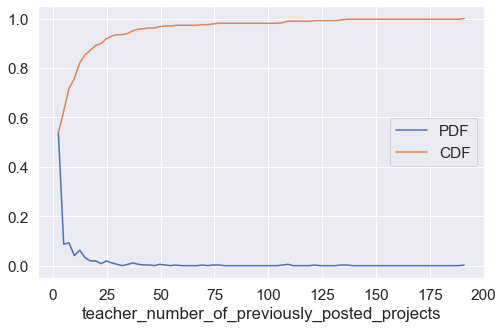

In [215]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

# 11.3. Applying Decision Trees on Average Word2Vec, SET 3

In [168]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb


DT = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth':(1,5,10,50,100,500) , 'min_samples_split':(5,10,100,500)}
DTREE3 = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
DTREE3.fit(Xtrain3, y_train)
print(DTREE3.best_estimator_)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


# 11.3.1. Finding The Best Hyperparameter "max_depth" and "min_samples_split"

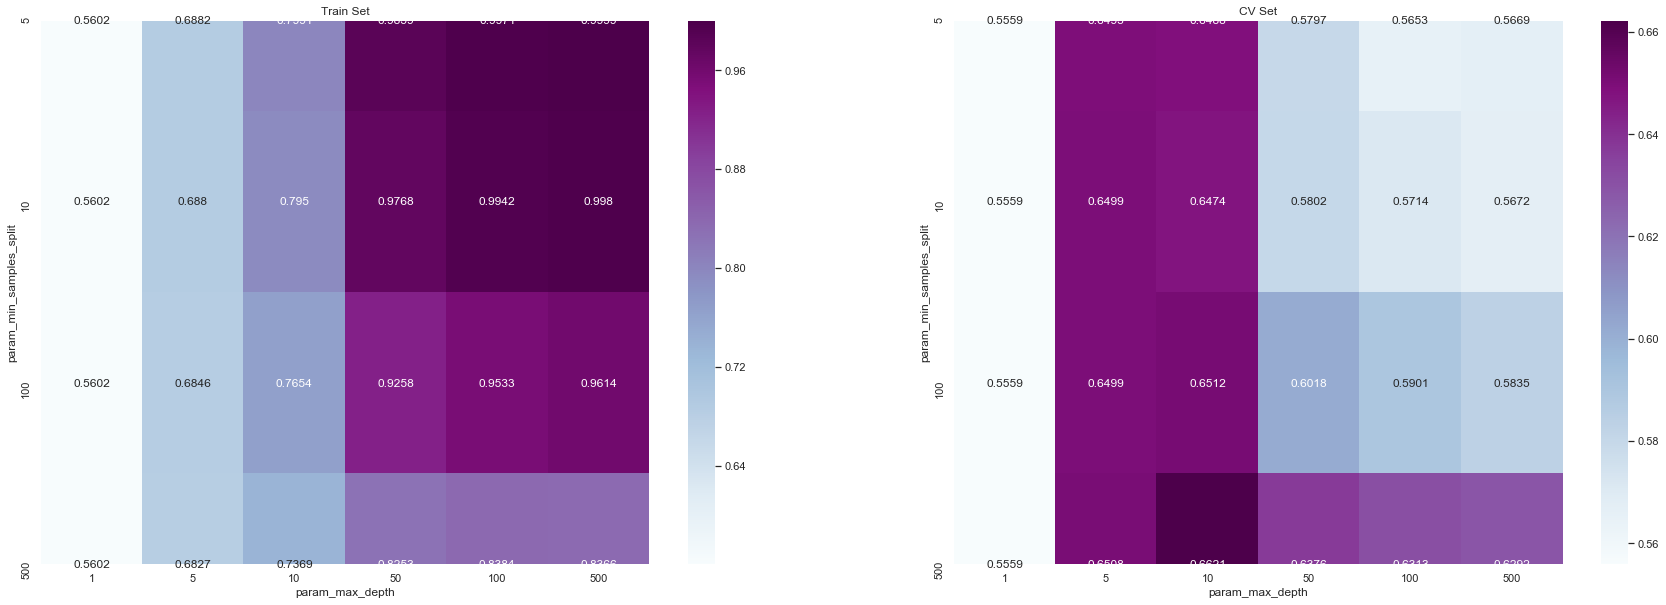

In [169]:
DTREE3 = pd.DataFrame(DTREE3.cv_results_)
max_scores_avg_w2v = DTREE3.groupby(['param_min_samples_split', 
                                    'param_max_depth']).max()
max_scores_avg_w2v = max_scores_avg_w2v.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_avg_w2v.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_avg_w2v.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [185]:
best_parameters_avg_w2v = [{'max_depth':[10], 'min_samples_split':[500] } ]

# 11.3.2. Testing the performance of the model on test data, plotting ROC Curves

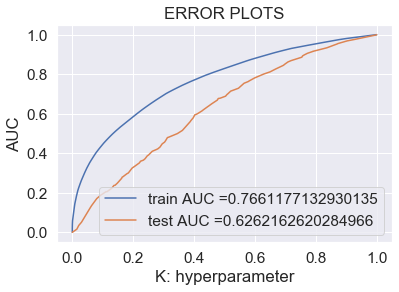

In [219]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


DT3 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 10 ,min_samples_split = 500)
DT3.fit(Xtrain3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_avg_w2v = DT3.predict_proba(Xtrain3)[:,1]    
y_test_pred_avg_w2v = DT3.predict_proba(Xtest3)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avg_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avg_w2v)

sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.3.4. Building Confusion matrix

In [173]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions_of_y

In [174]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_w2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_w2v, best_t)))

the maximum value of tpr*(1-fpr) 0.40796507583989244 for threshold 0.507
Train confusion matrix
[[ 2162  1301]
 [ 6578 12404]]
Test confusion matrix
[[1441 1105]
 [4927 9027]]


In [175]:
confusion_matrix_train_avg_w2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_w2v, best_t)))
confusion_matrix_test_avg_w2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_w2v, best_t)))

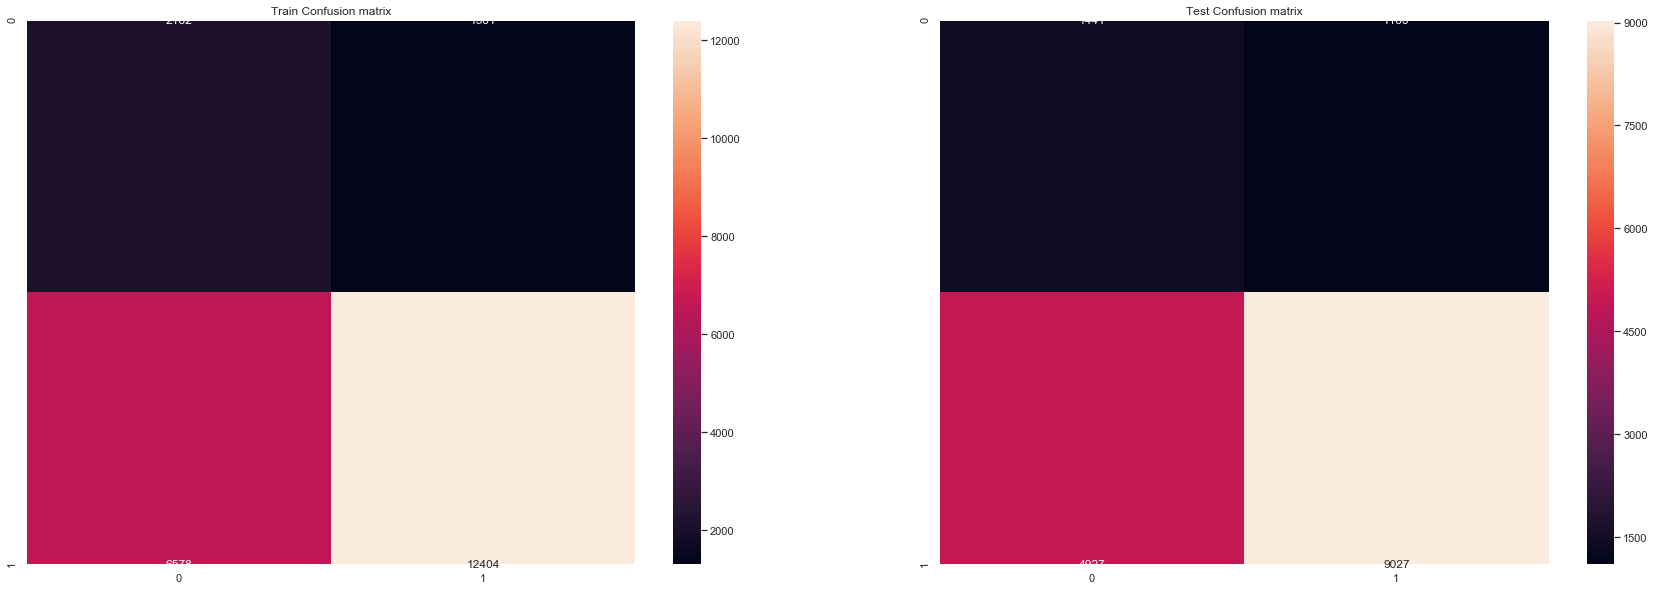

In [176]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_avg_w2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_avg_w2v,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.3.5. Extracting False Positives

In [177]:
FalsePositive_avg_w2v = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions_of_y[i] == 1) :
        FalsePositive_avg_w2v.append(i)
fp_essay_avg_w2v = []
for i in FalsePositive_avg_w2v :
    fp_essay_avg_w2v.append(X_test['preprocessed_essays'].values[i])

# 11.3.6. Word Cloud

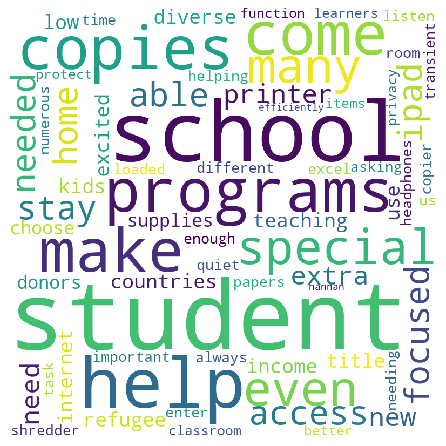

In [178]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay_avg_w2v :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [179]:
cols = X_test.columns
cols
X_test_falsePos = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in FalsePositive_avg_w2v : # (in fpi all the false positives data points indexes)
        X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i], axis=0))

# 11.3.7. Box Plot for 'price' data

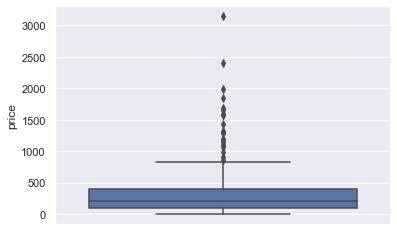

In [180]:
sns.boxplot(y='price', data=X_test_falsePos)

# 11.3.8. PDF and CDF for 'teacher_number_of_previously_posted_projects' data

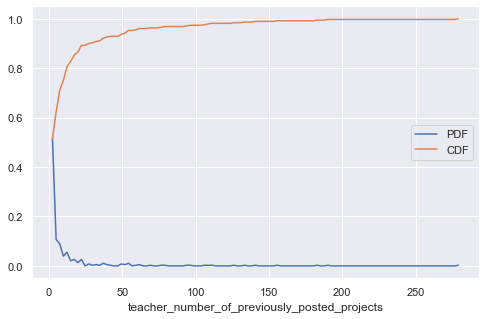

In [181]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

# 11.4. Applying Decision Trees on Weighted TFIDF Word2Vec, SET 4

In [182]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb


DT = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth':(1,5,10,50,100,500) , 'min_samples_split':(5,10,100,500)}
DTREE4 = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
DTREE4.fit(Xtrain4, y_train)
print(DTREE4.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


# 11.4.1. Finding The Best Hyperparameter "max_depth" and "min_samples_split"

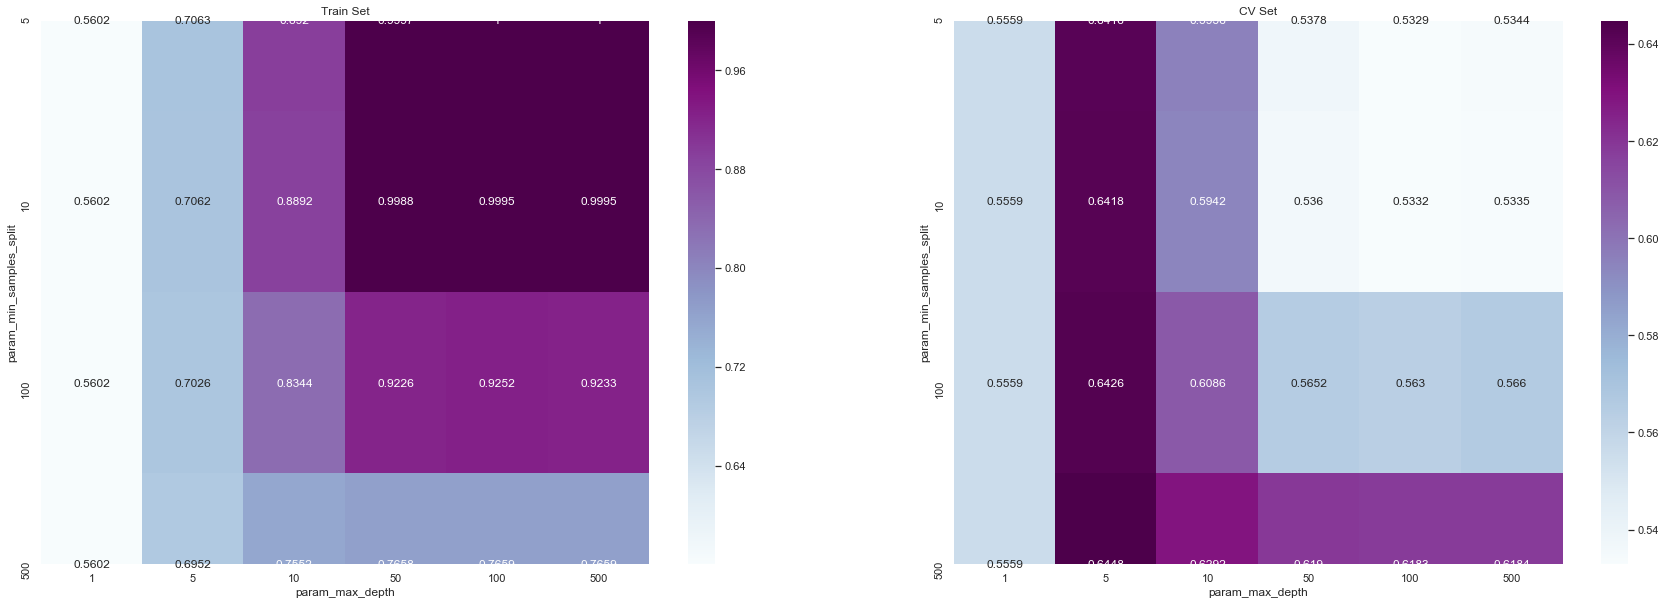

In [183]:
DTREE4 = pd.DataFrame(DTREE4.cv_results_)
max_scores_tfidff_weighted_w2v = DTREE4.groupby(['param_min_samples_split', 
                                    'param_max_depth']).max()
max_scores_tfidff_weighted_w2v = max_scores_tfidff_weighted_w2v.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_tfidff_weighted_w2v.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_tfidff_weighted_w2v.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [196]:
best_parameters_tfidff_weighted_w2v = [{'max_depth':[10], 'min_samples_split':[500] } ]

# 11.4.2. Testing the performance of the model on test data, plotting ROC Curves

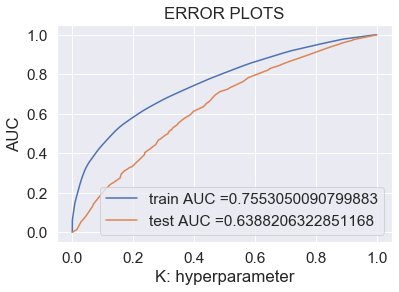

In [220]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


DT4 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 10 ,min_samples_split=500)
DT4.fit(Xtrain4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf_weighted_w2v = DT4.predict_proba(Xtrain4)[:,1]    
y_test_pred_tfidf_weighted_w2v = DT4.predict_proba(Xtest4)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf_weighted_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf_weighted_w2v)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.4.3. Building Confusion Matrix

In [185]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions_of_y

In [186]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_weighted_w2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_weighted_w2v, best_t)))

the maximum value of tpr*(1-fpr) 0.4120716457279937 for threshold 0.489
Train confusion matrix
[[ 2312  1151]
 [ 7266 11716]]
Test confusion matrix
[[1549  997]
 [5406 8548]]


In [187]:
confusion_matrix_train_tfidf_weighted_w2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_weighted_w2v, best_t)))
confusion_matrix_test_tfidf_weighted_w2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_weighted_w2v, best_t)))

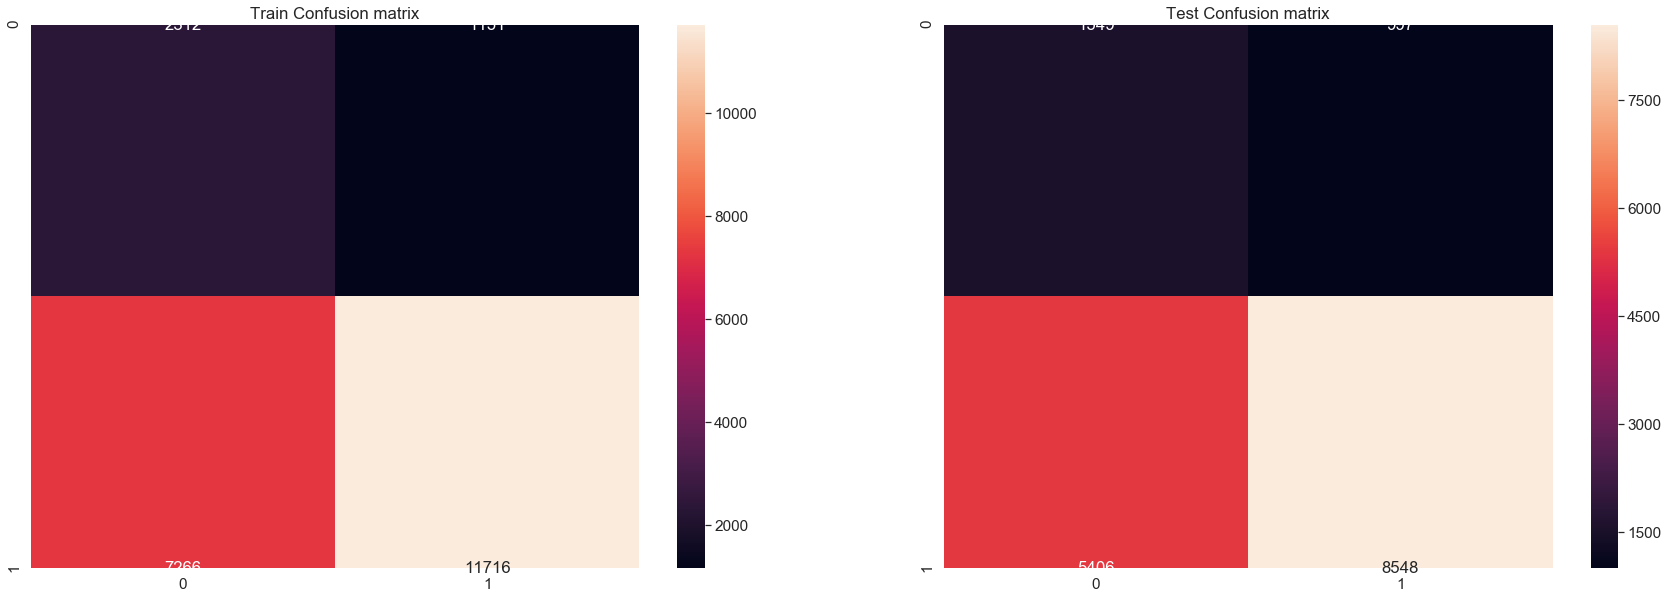

In [188]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf_weighted_w2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf_weighted_w2v,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.4.4. Extracting False Positives

In [189]:
FalsePositive_tfidf_weighted_w2v = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions_of_y[i] == 1) :
        FalsePositive_tfidf_weighted_w2v.append(i)
fp_essay_tfidf_weighted_w2v = []
for i in FalsePositive_tfidf_weighted_w2v :
    fp_essay_tfidf_weighted_w2v.append(X_test['preprocessed_essays'].values[i])

# 11.4.5. Word Cloud

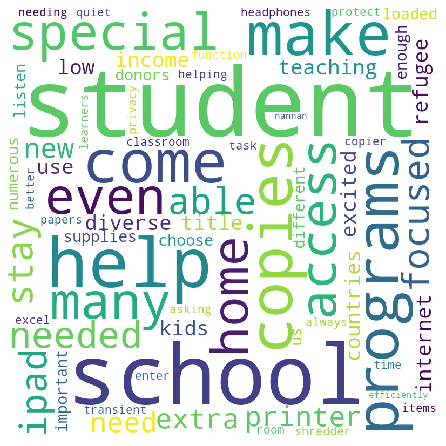

In [190]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay_tfidf_weighted_w2v :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [191]:
cols = X_test.columns
cols
X_test_falsePos = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in FalsePositive_tfidf_weighted_w2v : # (in fpi all the false positives data points indexes)
        X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i], axis=0))

# 11.4.6. Boxplot for 'price' data

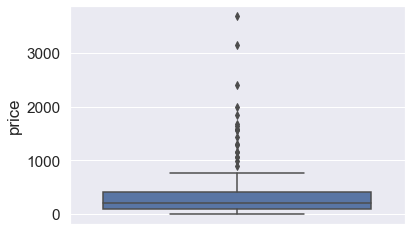

In [192]:
sns.boxplot(y='price', data=X_test_falsePos)

# 11.4.7. PDF and CDF for 'teacher_number_of_previously_posted_projects' data

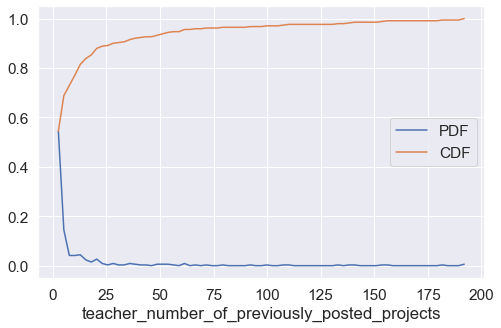

In [193]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

# 12. Finding Top 5000 features of SET2 using Decision Trees's Feature_importances_

In [110]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb
DT = DecisionTreeClassifier(class_weight = "balanced")
DTREE5 = DT.fit(Xtrain2,y_train)
newX = DTREE5.feature_importances_

In [111]:
newX

array([0., 0., 0., ..., 0., 0., 0.])

##### The above values which we got as 0 means that column is not selected in top 5000

In [290]:
# k = 5000
# ind = DTREE5.feature_importances_.argsort()[-k:][::-1]
# X_train_shortlisted = Xtrain2[:,ind]

In [295]:
# (X_train_shortlisted.shape)

(22445, 5000)

# 12.1. Function for returning top 5000 features

In [108]:
def bestFeatures(model, X, k=5000):
    return X[:,model.feature_importances_.argsort()[-k:][::-1]]


In [112]:
Xtrain5 = bestFeatures(DTREE5,Xtrain2,5000)
Xtest5 = bestFeatures(DTREE5, Xtest2, 5000)
Xcv5 = bestFeatures(DTREE5,Xcv2,5000)
print(Xtrain5.shape)
print(Xtest5.shape)
print(Xcv5.shape)

(22445, 5000)
(16500, 5000)
(11055, 5000)


In [113]:
print(Xtrain5)  

  (0, 630)	1.0
  (0, 148)	1.0
  (0, 540)	1.0
  (0, 0)	0.008456403763024662
  (0, 1)	0.0022246941045606225
  (0, 4)	0.004878048780487805
  (0, 4850)	0.09563634909495991
  (0, 436)	0.04386698360456328
  (0, 4945)	0.09363890253003687
  (0, 153)	0.17785161411955164
  (0, 586)	0.07803915652616256
  (0, 253)	0.045216150203112294
  (0, 4011)	0.06662151328724232
  (0, 400)	0.07365440176690831
  (0, 3)	0.04277188755141287
  (0, 387)	0.05689284051182552
  (0, 4808)	0.10236875617477335
  (0, 434)	0.05576055982907345
  (0, 750)	0.0864904416885331
  (0, 687)	0.10696141399750818
  (0, 206)	0.0590880843141432
  (0, 70)	0.0317695466347216
  (0, 14)	0.029136124861913165
  (0, 242)	0.04224318259670466
  (0, 1090)	0.05876675777839184
  :	:
  (22444, 18)	0.07584075499939126
  (22444, 2349)	0.06441667545224858
  (22444, 89)	0.026368098862423636
  (22444, 2092)	0.07102900513595119
  (22444, 2)	0.014228448745647252
  (22444, 63)	0.05474189119382864
  (22444, 37)	0.0787086478555171
  (22444, 249)	0.0669880655

In [114]:
print(Xtrain5.shape)  
print(Xtest5.shape)  
print(Xcv5.shape)  

(22445, 5000)
(16500, 5000)
(11055, 5000)


# 12.2. Applying Logistic Regression on Our Top features

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20054.05it/s]


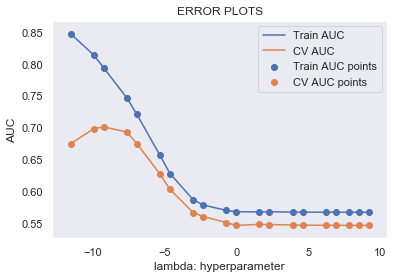

In [115]:
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i , max_iter = 1000,class_weight = 'balanced')
    LR.fit(Xtrain5, y_train)

    y_train_pred_tfidf5 = LR.predict_proba(Xtrain5)[:,1]    
    y_cv_pred_tfidf5 = LR.predict_proba(Xcv5)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_tfidf5))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_tfidf5))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)
    
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [116]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_set5 = optimal_alpha_cv
print(best_alpha_set5)

Maximum AUC score of cv is: 0.7014625746859661
Corresponding alpha value of cv is: 0.0001 

0.0001


In [117]:
# best_alpha = 0.003

# 12.3. Testing the performance of the model on test data, plotting ROC Curves

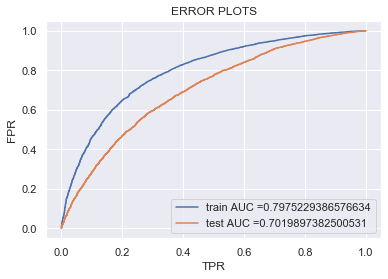

In [118]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR =SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_set5 , max_iter = 1000,class_weight = 'balanced')
LR.fit(Xtrain5, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf5 = LR.predict_proba(Xtrain5)[:,1]    
y_test_pred_tfidf5 = LR.predict_proba(Xtest5)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf5)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf5)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [119]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions_of_y

In [121]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf5, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf5, best_t)))

the maximum value of tpr*(1-fpr) 0.5332385046270716 for threshold 0.487
Train confusion matrix
[[ 2495   968]
 [ 4933 14049]]
Test confusion matrix
[[ 1454  1092]
 [ 3952 10002]]


In [122]:
confusion_matrix_train_lr_set5 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf5, best_t)))
confusion_matrix_test_lr_set5 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf5, best_t)))

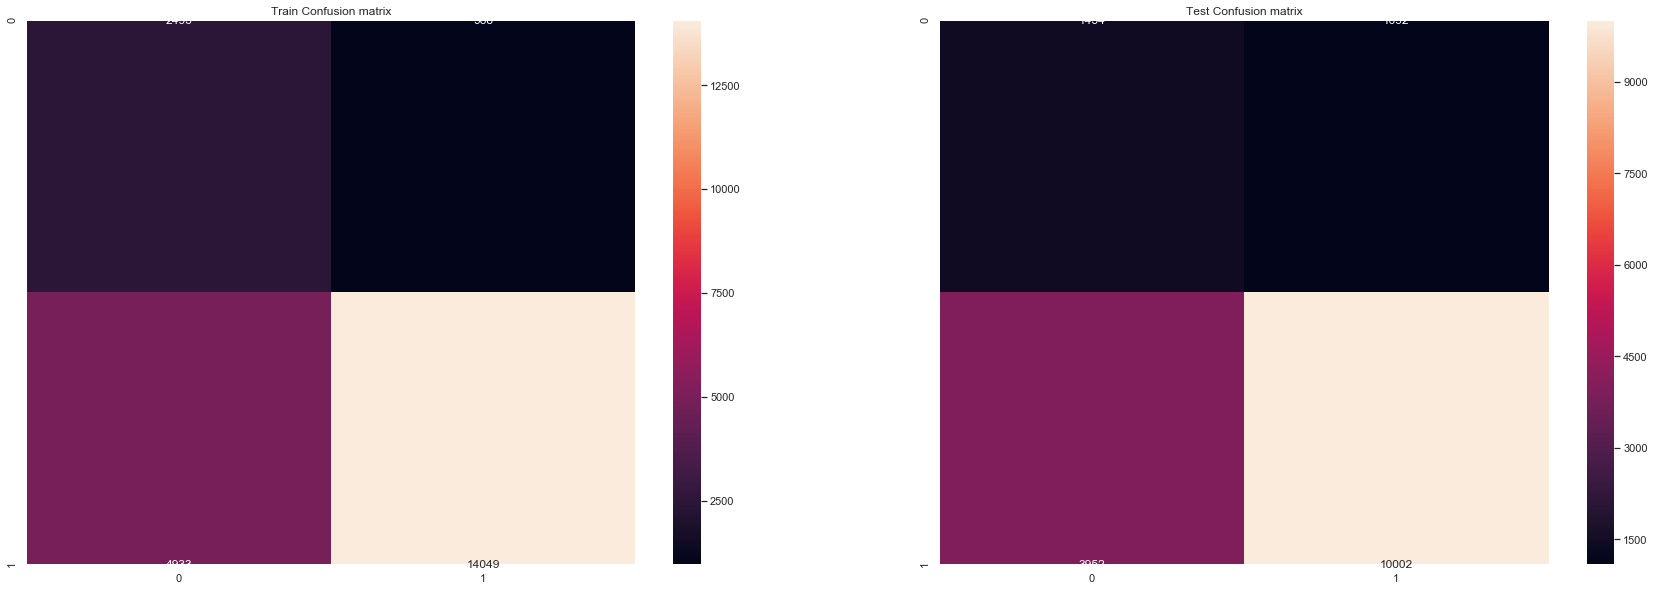

In [124]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_lr_set5,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_lr_set5,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.4. Applying Decission Tree on Our Top features

In [125]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb


DT = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth':(1,5,10,50,100,500) , 'min_samples_split':(5,10,100,500)}
DTREE6 = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
DTREE6.fit(Xtrain5, y_train)
print(DTREE6.best_estimator_)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


# 12.5. Finding The Best Hyperparameter "max_depth" and "min_samples_split"

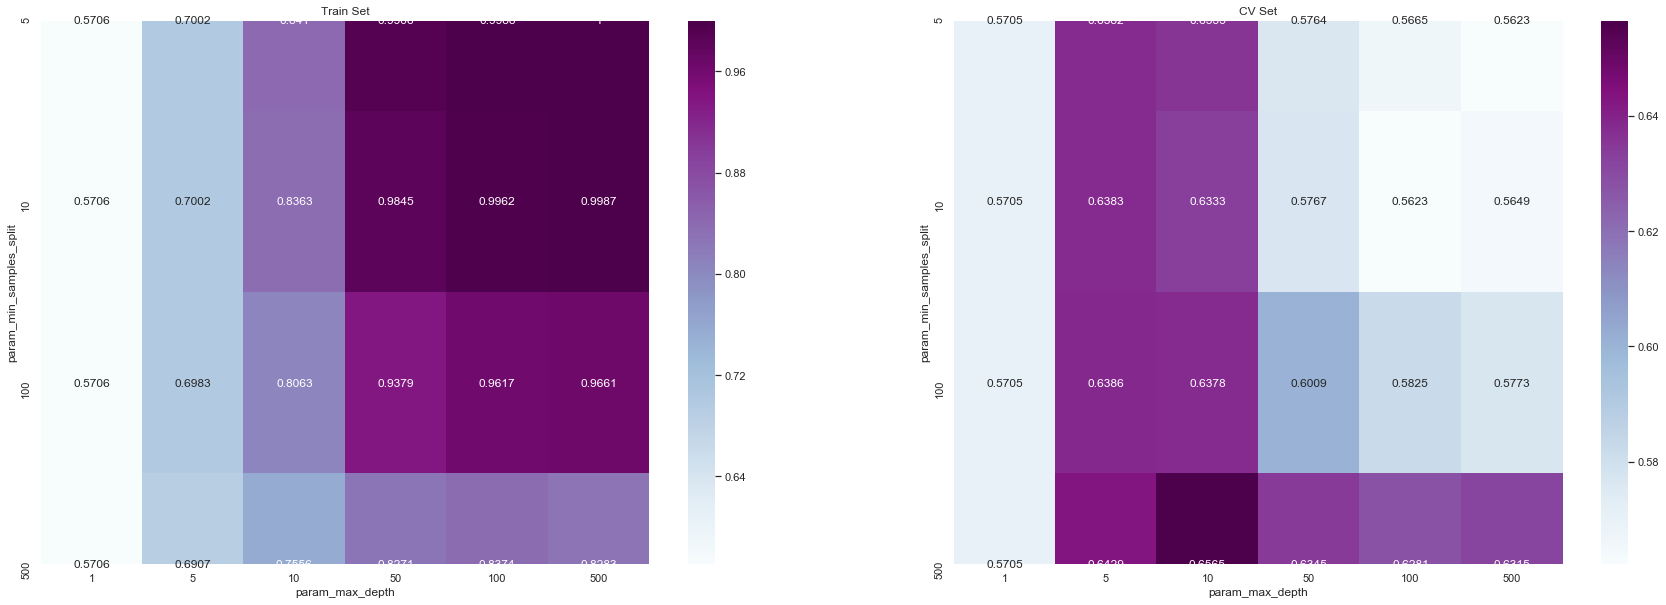

In [127]:
DTREE6 = pd.DataFrame(DTREE6.cv_results_)
max_scores_5 = DTREE6.groupby(['param_min_samples_split', 
                                    'param_max_depth']).max()
max_scores_5 = max_scores_5.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_5.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_5.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 12.6. Testing the performance of the model on test data, plotting ROC Curves

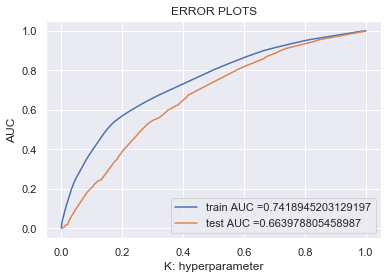

In [128]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


DT6 = DecisionTreeClassifier(class_weight = 'balanced', max_depth=10,min_samples_split=500)
DT6.fit(Xtrain5, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_set5 = DT6.predict_proba(Xtrain5)[:,1]    
y_test_pred_set5 = DT6.predict_proba(Xtest5)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_set5)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_set5)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 12.7. Building Confusion Matrix

In [129]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions_of_y

In [130]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set5, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set5, best_t)))

the maximum value of tpr*(1-fpr) 0.4630293093753607 for threshold 0.463
Train confusion matrix
[[ 2519   944]
 [ 6899 12083]]
Test confusion matrix
[[1567  979]
 [5215 8739]]


In [131]:
confusion_matrix_train_set5 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set5, best_t)))
confusion_matrix_test_set5 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set5, best_t)))

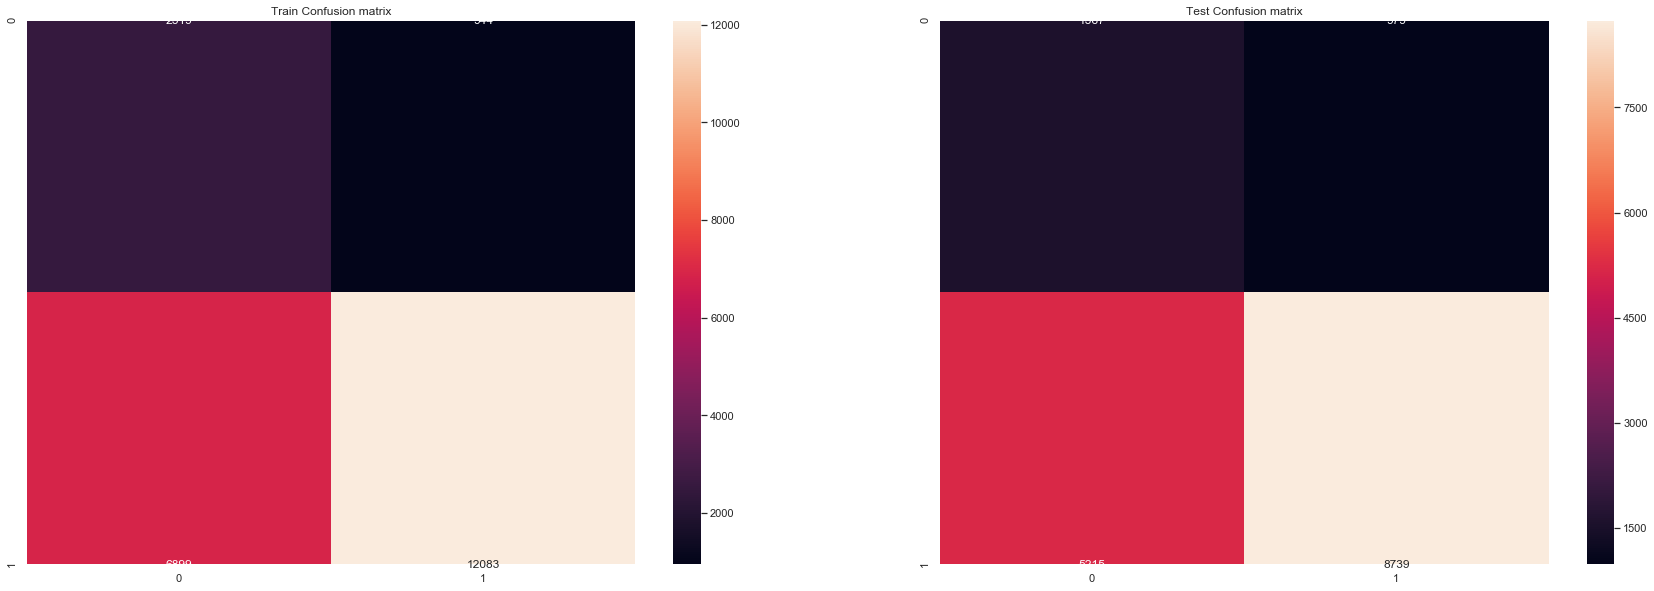

In [132]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_set5,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_set5,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13. Conclusion

In [133]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Max Depth","Min Sample Split", "Train AUC" , "Test AUC"]

x.add_row(["BOW", "Decision Tree", 10,500, 0.7416,0.6750])
x.add_row(["TFIDF", "Decision Tree", 10,500, 0.7582, 0.6699])
x.add_row(["W2V","Decision Tree", 10,500, 0.7661,0.6262])
x.add_row(["TFIDF W2V","Decision Tree", 10,500, 0.7553, 0.6388])
x.add_row(["SET5","Decision Tree", 10,500, 0.7418, 0.6639])



In [134]:
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

y = PrettyTable()

y.field_names = ["Vectorizer", "Model", "Alpha", "Train AUC" , "Test AUC"]


y.add_row(["SET5","Logistic Regression", 0.0001, 0.7975, 0.7019])


In [135]:
print(x)
print(y)

+------------+---------------+-----------+------------------+-----------+----------+
| Vectorizer |     Model     | Max Depth | Min Sample Split | Train AUC | Test AUC |
+------------+---------------+-----------+------------------+-----------+----------+
|    BOW     | Decision Tree |     10    |       500        |   0.7416  |  0.675   |
|   TFIDF    | Decision Tree |     10    |       500        |   0.7582  |  0.6699  |
|    W2V     | Decision Tree |     10    |       500        |   0.7661  |  0.6262  |
| TFIDF W2V  | Decision Tree |     10    |       500        |   0.7553  |  0.6388  |
|    SET5    | Decision Tree |     10    |       500        |   0.7418  |  0.6639  |
+------------+---------------+-----------+------------------+-----------+----------+
+------------+---------------------+--------+-----------+----------+
| Vectorizer |        Model        | Alpha  | Train AUC | Test AUC |
+------------+---------------------+--------+-----------+----------+
|    SET5    | Logistic Regr